# Multilayer SBM: Extension upon TopSBM 

A basic tutorial showing how to process Wikipedia data, fit a multilayer network and retrieve topics associated to consensus partition.

## Load in data

First we retrieve the Wikipedia datasets.

In [8]:
!unzip "./dataset-four.zip"

Archive:  ./dataset-four.zip
   creating: dataset-four/
  inflating: __MACOSX/._dataset-four  
  inflating: dataset-four/.DS_Store  
  inflating: __MACOSX/dataset-four/._.DS_Store  
   creating: dataset-four/data/
  inflating: __MACOSX/dataset-four/._data  
  inflating: dataset-four/data/.DS_Store  
  inflating: __MACOSX/dataset-four/data/._.DS_Store  
   creating: dataset-four/data/dataset-four/
  inflating: __MACOSX/dataset-four/data/._dataset-four  
  inflating: dataset-four/data/dataset-four/.DS_Store  
  inflating: __MACOSX/dataset-four/data/dataset-four/._.DS_Store  
   creating: dataset-four/data/dataset-four/Corpus/
  inflating: __MACOSX/dataset-four/data/dataset-four/._Corpus  
   creating: dataset-four/data/dataset-four/processed/
  inflating: __MACOSX/dataset-four/data/dataset-four/._processed  
   creating: dataset-four/data/dataset-four/raw/
  inflating: __MACOSX/dataset-four/data/dataset-four/._raw  
  inflating: dataset-four/data/dataset-four/Corpus/.DS_Store  
  inflati

In [27]:
from random import choice
import scipy.stats
import sys
import gi
from gi.repository import Gtk, Gdk
import graph_tool.all as gt
import pandas as pd
import numpy as np
import os
import time

def retrieve_data(path_data):
    """
    Retrieve the text, titles, mapping of articles to categories, graph construction,
    and the true partition of the label.
    """

    # Read in text data associated with each article
    fname_data = 'processed/corpus.txt'
    filename = os.path.join(path_data, fname_data)
    with open(filename,'r', encoding = 'utf8') as f:
        x = f.readlines()
    texts = [h.split() for h in x]

    # Read in titles data associated with each article
    fname_data = 'processed/titles.txt'
    filename = os.path.join(path_data, fname_data)
    with open(filename,'r', encoding = 'utf8') as f:
        x = f.readlines()
    titles = [h.replace("\n", "") for h in x]

    # We retrieve the Wikipedia label Category of each article
    category_titles_path = "raw/corpus_categoryTitle.csv"
    category_title = pd.read_csv(os.path.join(path_data, category_titles_path), sep = "\t")

    # Read in hyperlink graph data
    hyperlink_edgelist = 'processed/hyperlink_edgelist.csv'
    hyperlink_g = gt.load_graph_from_csv(os.path.join(path_data, hyperlink_edgelist),
                              skip_first=True,
                              directed=True,
                              csv_options={'delimiter': '\t', 'quotechar': '"'})
    num_vertices = hyperlink_g.num_vertices()
    num_edges = hyperlink_g.num_edges()

    # Create hyperlinks list
    filename = os.path.join(path_data, hyperlink_edgelist)
    x = pd.read_csv(filename, delimiter = "\t")
    hyperlinks = [(row[0],row[1]) for source, row in x.iterrows()]

    # Assign label based on category to each wikipedia article node.
    # Dict mapping between wikipedia article and category
    article_category = {}
    for index, row in category_title.iterrows():
        article_category[row[2]] = row[0]

    # Category types in this dataset
    print(set(category_title.category))

    # We need to assign wikipedia category to every wiki article
    label = hyperlink_g.vp["label"] = hyperlink_g.new_vp("string")
    name = hyperlink_g.vp["name"] # every vertex has a name already associated to it!

    # We now assign category article to each Wikipedia article
    for v in hyperlink_g.vertices():
        category_of_article = article_category[name[v]]
        label[v] = category_of_article # assign wikipedia category to article
        
    # Retrieve true partition of graph
    true_partition = list(hyperlink_g.vp.label)    
    # Retrieve ordering of articles
    article_names = list(hyperlink_g.vp.name)

    # Remove parallel edges in hyperlink graph
    gt.remove_parallel_edges(hyperlink_g)
    unique_hyperlinks = []
    for e in hyperlinks:
        if e not in unique_hyperlinks:
            unique_hyperlinks.append(e)

    return texts, titles, category_title, article_category, hyperlink_g, unique_hyperlinks, label, name, true_partition, article_names

In [28]:
path_data = f"./dataset-four/data/dataset-four"
texts, titles, category_title, article_category, hyperlink_g, hyperlinks, label, name,true_partition, article_names = retrieve_data(path_data)

{'Category:Fields of mathematics', 'Category:Subfields of physics', 'Category:Branches of biology'}


In [29]:
# Remove stop words in text data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

edited_text = []
# Recall texts is list of lists of words in each document.
for doc in texts:
    temp_doc = []
    for word in doc:
        if word not in stopwords.words('english'):
            temp_doc.append(word)
    edited_text.append(temp_doc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Display what original network with Wikipedia labels look like.

Original Wikipedia partition


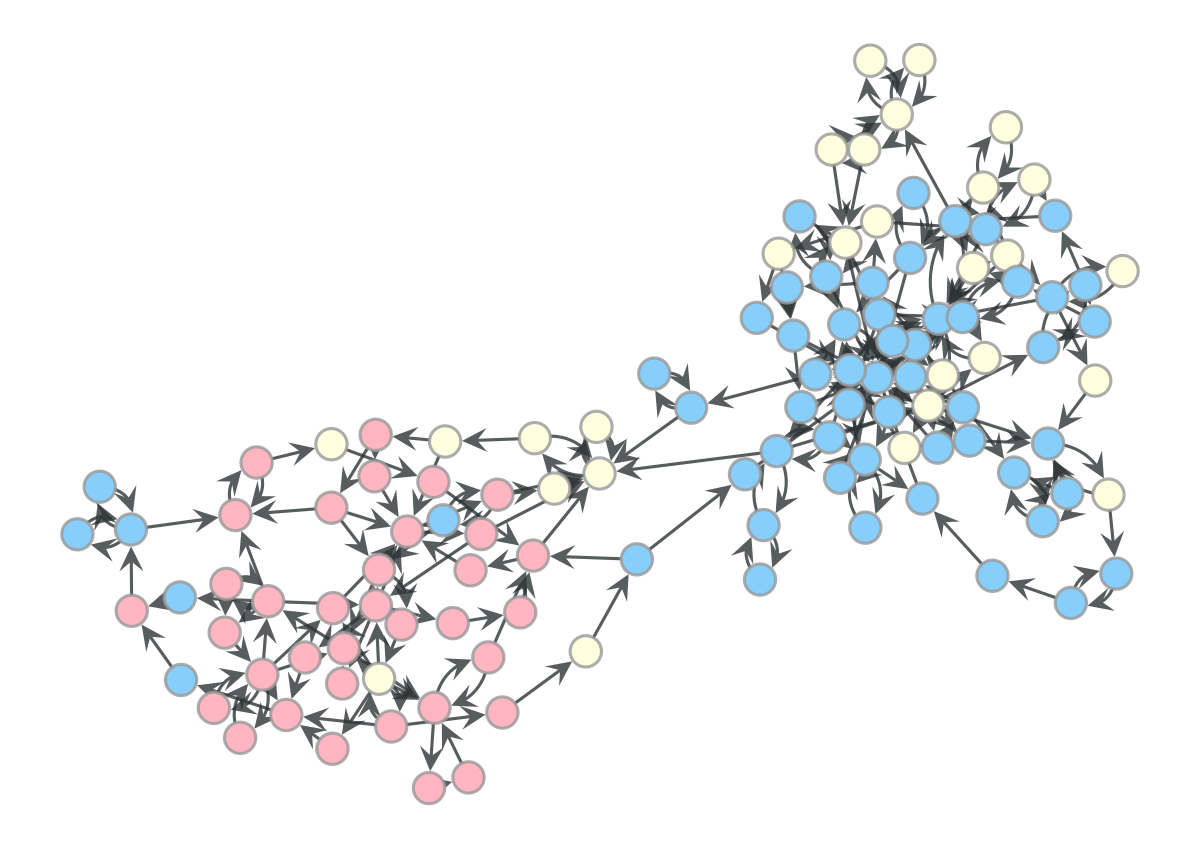

Color palette is
{'Category:Fields of mathematics': 'lightskyblue', 'Category:Subfields of physics': 'lightyellow', 'Category:Branches of biology': 'lightpink'}


In [30]:
print("Original Wikipedia partition")
# To assign color to each node.
vertex_color = hyperlink_g.vp["vertex_color"] = hyperlink_g.new_vp("string")
pos = hyperlink_g.vp["pos"] = gt.sfdp_layout(hyperlink_g)

# Establish color palette for graph by mapping category to color.
colors = {}
palette = ["lightskyblue", "lightyellow", "lightpink"] # ASSUMING 3 CATEGORIES!
for cat, col in zip(set(article_category.values()), palette):
    colors[cat] = col

# Assign color palette to each node
for v in hyperlink_g.vertices():
    vertex_color[v] = colors[label[v]] # retrieve category of article and retrieve color

# Visualise graph
gt.graph_draw(hyperlink_g,
              pos=hyperlink_g.vp["pos"],
              vertex_fill_color=hyperlink_g.vp.vertex_color, 
              inline = True)
print("Color palette is")
print(colors)

### Model Fitting 

#### Fitting the Hyperlink + Text model

We now fit a 2-layer SBM with one layer being the text layer (see TopSBM) composing of a bipartite network of document and word nodes whilst the hyperlink layer consists of hyperlinks between document nodes.

In [31]:
from sbmmultilayer import *

In [32]:
SEED_NUM = 32

In [33]:
def fit_hyperlink_text_hsbm(edited_text, titles, hyperlinks, N_iter):
    """
    Fit N_iter iterations of doc-network sbm on dataset through agglomerative heuristic
    and simulated annealing.
    """
    hyperlink_text_hsbm_post = []
    hyperlink_text_hsbm_result = []

    for _ in range(N_iter):
        print(f"Iteration {_}")
        # Construct 2-layer network hyperlink-text model and fit multilayer SBM.
        hyperlink_text_hsbm = sbmmultilayer(random_seed=SEED_NUM)
        hyperlink_text_hsbm.make_graph(edited_text, titles, hyperlinks)
        hyperlink_text_hsbm.fit()

        # Retrieve state from simulated annealing hSBM
        hyperlink_text_hsbm_post_state, results_sim_anneal = run_multiflip_simulated_annealing_hsbm(hyperlink_text_hsbm)

        # Update hSBM model using state from simulated annealing
        updated_hsbm_model = hyperlink_text_hsbm
        updated_hsbm_model.state = hyperlink_text_hsbm_post_state
        updated_hsbm_model.mdl = hyperlink_text_hsbm_post_state.entropy()
        updated_hsbm_model.n_levels = len(hyperlink_text_hsbm_post_state.levels)

        # Save the results from simulated annealing
        hyperlink_text_hsbm_post.append(updated_hsbm_model)
        hyperlink_text_hsbm_result.append(results_sim_anneal)

    return hyperlink_text_hsbm_post, hyperlink_text_hsbm_result 


def run_multiflip_simulated_annealing_hsbm(hsbm_model):
    """
    Run multiflip simualted annealing on multilayer SBM.
    Return:
        hsbm_state_copy - State associated to SBM at the end of simulated annealing.
        final_results_multiflip - (nattempts, nmoves, entropy) associated to simulated annealing.
    """
    S1 = hsbm_model.mdl
    print(f"Initial entropy is {S1}")

    # We create a copy and perform simulated annealing on the copy to retain
    # original hSBM state.
    init_hsbm_state = hsbm_model.state

    # Allows for higher levels of groups to be formed
    hsbm_state_copy = init_hsbm_state.copy(bs=init_hsbm_state.get_bs() + [np.zeros(1)]*4, sampling=True)

    # Fit simulated annealing and store results.
    final_results_multiflip = []
    results_multiflip = gt.mcmc_equilibrate(hsbm_state_copy, force_niter=1000, mcmc_args=dict(beta=1),history=True)
    final_results_multiflip.extend(results_multiflip)
    results_multiflip = gt.mcmc_equilibrate(hsbm_state_copy, force_niter=4000, mcmc_args=dict(beta=np.inf),history=True)    
    final_results_multiflip.extend(results_multiflip)

    S2 = hsbm_state_copy.entropy()
    print(f"New entropy is {S2}")
    print(f"Improvement after simulated annealing {S2 - S1}")
    print(f"The improvement percentage is { ((S2 - S1)/S1) * 100 }")

    return hsbm_state_copy, final_results_multiflip

Execute multiple runs of fitting multilayer SBM with simualted annealing.

In [34]:
start = time.time()
hyperlink_text_hsbm_states, hyperlink_text_hsbm_results =  fit_hyperlink_text_hsbm(edited_text, titles, hyperlinks, 3)
end = time.time()
print(end - start)

Iteration 0
Initial entropy is 281602.58305185626
New entropy is 272524.56261042046
Improvement after simulated annealing -9078.020441435801
The improvement percentage is -3.223699279691661
Iteration 1
Initial entropy is 281602.58305185626
New entropy is 266931.9345564941
Improvement after simulated annealing -14670.64849536214
The improvement percentage is -5.209699547628292
Iteration 2
Initial entropy is 281602.58305185626
New entropy is 272235.25910546485
Improvement after simulated annealing -9367.323946391407
The improvement percentage is -3.3264339569876893
3233.504738807678


### Visualise Results

Visualise the results from simulated annealing. Examine the description length and autocorrelation.

In [35]:
import matplotlib.pyplot as plt 

%matplotlib inline 

def visualise_multiflip_sim_annealing(results):
    """
    Visualise the multiflip simulated annealing by analysing the description length.
    """    
    # Retrieve figures needed to plot MDL
    # Retrieve MDL data from multiflip function
    fig, ax = plt.subplots(1, figsize = (15, 10))
    count_i = 0
    for results_sim_anneal in results:
        mdls = []
        mdl_temp = []
        for row in range(len(results_sim_anneal)):
            mdls.append(results_sim_anneal[row][2])

        # Compute mean and std for plotting.
        mdl_averages = [np.average(mdl) for mdl in mdls]
        mdl_std = [np.std(mdl) for mdl in mdls]
        plt.plot(range(len(results_sim_anneal)), mdls,"^", markersize=1, label=count_i)
        count_i += 1
    plt.xlabel("MCMC Sweeps")
    plt.ylabel(r"Description length $\Sigma$")
    plt.legend()
    plt.title("Description length of MCMC over sweeps")

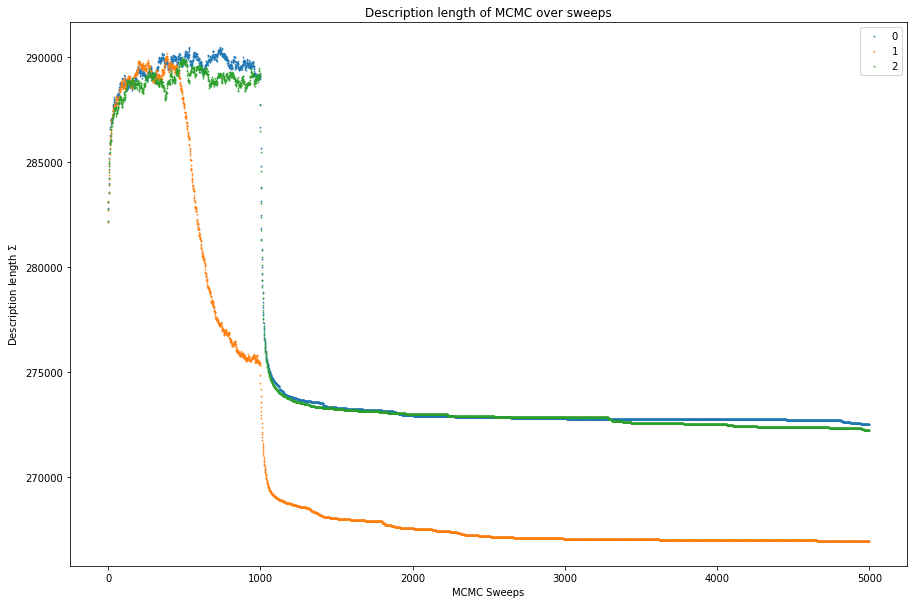

In [36]:
visualise_multiflip_sim_annealing(hyperlink_text_hsbm_results)

In [38]:
import pymc3 as pm3

LAGS_LIMIT = 1500

def compute_autocorrelation_plot(results, model):
    """   
    Plot the autocorrelation plot to show mixing time.
    """
    fig, ax = plt.subplots()
    for iteration in range(len(results)):
        mdls = [entry[2] for entry in results[iteration]] # this is the MDL for each realisation
        
        lags = np.arange(1, LAGS_LIMIT)
        values = np.array(mdls)    
        ax.plot(lags, [pm3.autocorr(values, l) for l in lags])
    _ = ax.set(xlabel=r'$\tau$ Lag', ylabel='Autocorrelation', ylim=(-.1, 1))
    plt.title(f'Autocorrelation Plot for {model} model')
    plt.show()

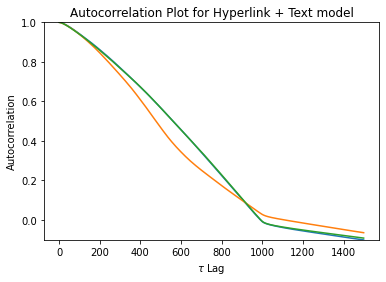

In [39]:
compute_autocorrelation_plot(hyperlink_text_hsbm_results, "Hyperlink + Text")

### Retrieve partitions

Retrieve the partitions assigned to the document nodes by examining the highest non-trivial level of the hierarchical degree-corrected SBM.

In [61]:
from Utils.nmi import *
from Utils.doc_clustering import *

def find_highest_non_trivial_group(num_levels, curr_hsbm):
    """
    Find the highest group that is not just 1 group.
    """
    top_levels = curr_hsbm.n_levels
    temp_l = 0
    highest_l = [temp_l]
    final_l = 0
    
    # Compute values of interest.
    clustering_info = doc_clustering("./", hyperlink_g)
    clustering_info.seeds = [0] # we only want 1 iteration.

    for i in range(top_levels):
        # Iterate until no longer high enough level.
        highest_l = [temp_l]
        doc_partitions, doc_num_groups, doc_entropies = clustering_info.collect_info("1-layer-doc", curr_hsbm.g, highest_l, curr_hsbm.state)
        if doc_num_groups == [1]:
            # We have found highest level we can go.
            final_l = i-1
            break
        # Still on non-trivial level, so still continue
        temp_l += 1
    highest_l = [final_l]
    doc_partitions, doc_num_groups, doc_entropies = clustering_info.collect_info("1-layer-doc", curr_hsbm.g, highest_l, curr_hsbm.state)
    print(f"We chose level {final_l} out of levels {num_levels}")
    print("Number of groups", doc_num_groups)
    print("\n")
    return doc_partitions, final_l


def get_hsbm_partitions(model_states):
    """
    For each mu, retrieve the partitions.
    """
    model_partitions = []
    levels = [] # store highest non-trivial level
    # Retrieve partitions
    for i in range(len(model_states)):
        curr_hsbm = model_states[i] #retrieve hSBM model       
        # Figure out top layer
        top_levels = curr_hsbm.n_levels
        print("Number of levels", top_levels)
        model_partition, highest_level = find_highest_non_trivial_group(top_levels, curr_hsbm)
        model_partitions.append(model_partition[0])
        levels.append(highest_level)
    return model_partitions, levels

In [62]:
# Retrieve partitions assigned to documents in each run. Also save index of highest non-trivial level.
hyperlink_text_hsbm_partitions, levels = get_hsbm_partitions(hyperlink_text_hsbm_states)

Number of levels 9
We chose level 2 out of levels 9
Number of groups [4]


Number of levels 9
We chose level 2 out of levels 9
Number of groups [4]


Number of levels 9
We chose level 2 out of levels 9
Number of groups [4]




## Consensus Partition

Compute the consensus partition assignment to document nodes over all the runs.

In [42]:
hyperlink_text_consensus_partitions, hyperlink_text_consensus_partitions_sd = gt.partition_overlap_center(hyperlink_text_hsbm_partitions)

In [43]:
def remap_color_partition_manually(partition, color_plate):
    """
    Manually map colors to partitions for visualisation.
    """
    block_groups = list(set(partition))
    color_map = {}
    for i in range(len(block_groups)):
        color_map[block_groups[i]] = color_plate[i]

    return color_map

Original Wikipedia partition


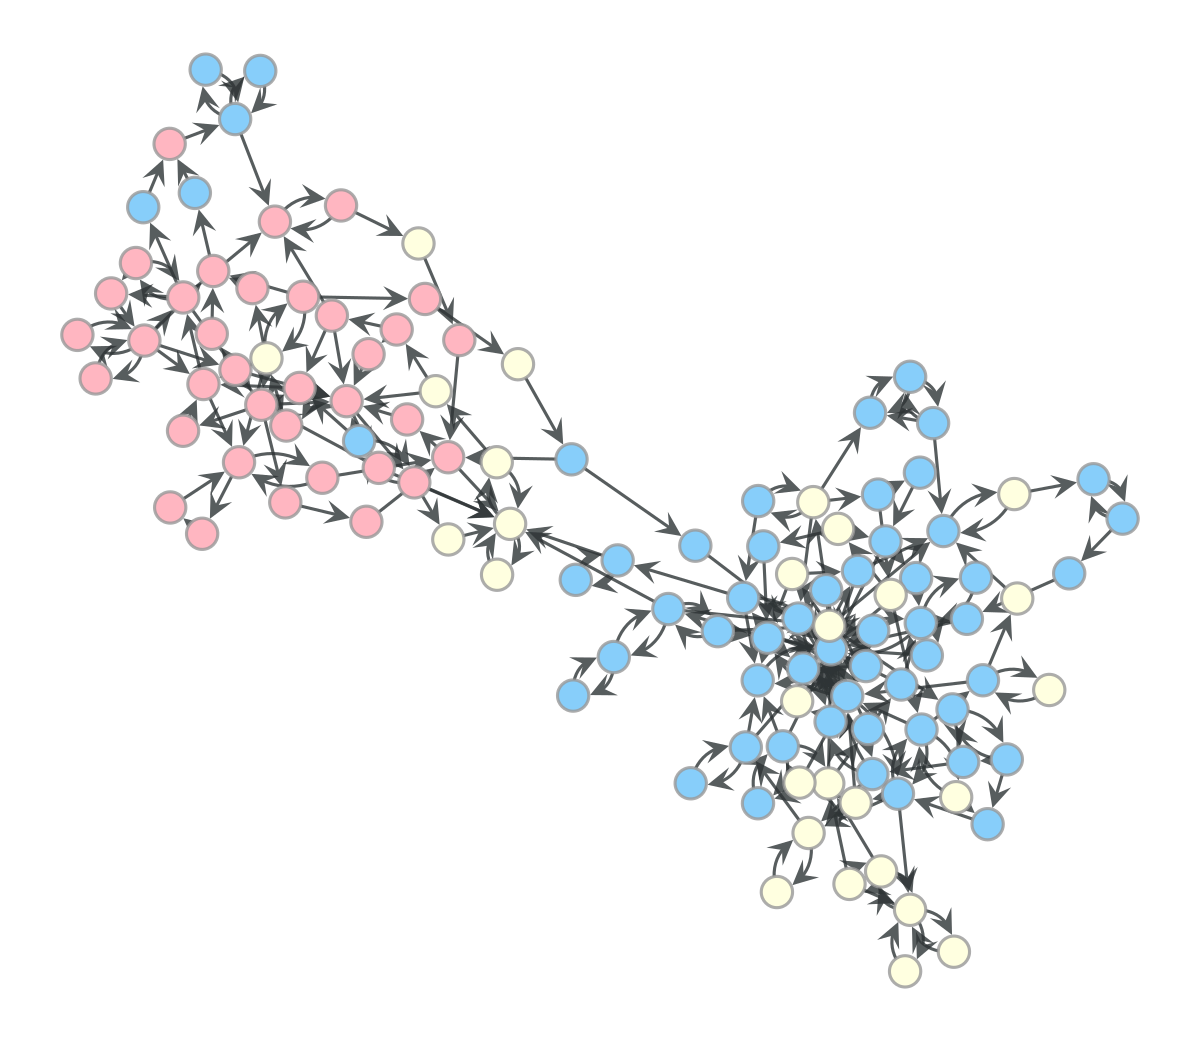

Color palette is
{'Category:Fields of mathematics': 'lightskyblue', 'Category:Subfields of physics': 'lightyellow', 'Category:Branches of biology': 'lightpink'}


In [44]:
print("Original Wikipedia partition")
# To assign color to each node.
vertex_color = hyperlink_g.vp["vertex_color"] = hyperlink_g.new_vp("string")
pos = hyperlink_g.vp["pos"] = gt.sfdp_layout(hyperlink_g)

# Establish color palette for graph by mapping category to color.
colors = {}
palette = ["lightskyblue", "lightyellow", "lightpink"] # ASSUMING 3 CATEGORIES!
for cat, col in zip(set(article_category.values()), palette):
    colors[cat] = col

# Assign color palette to each node
for v in hyperlink_g.vertices():
    vertex_color[v] = colors[label[v]] # retrieve category of article and retrieve color

# Visualise graph
gt.graph_draw(hyperlink_g,
              pos=hyperlink_g.vp["pos"],
              vertex_fill_color=hyperlink_g.vp.vertex_color, 
              inline = True)
print("Color palette is")
print(colors)

Visualise consensus partition from hyperlink + text model.

Hyperlink + Text Consensus Partition
Uncertainty associated to consensus partition is  0.04444444444444451


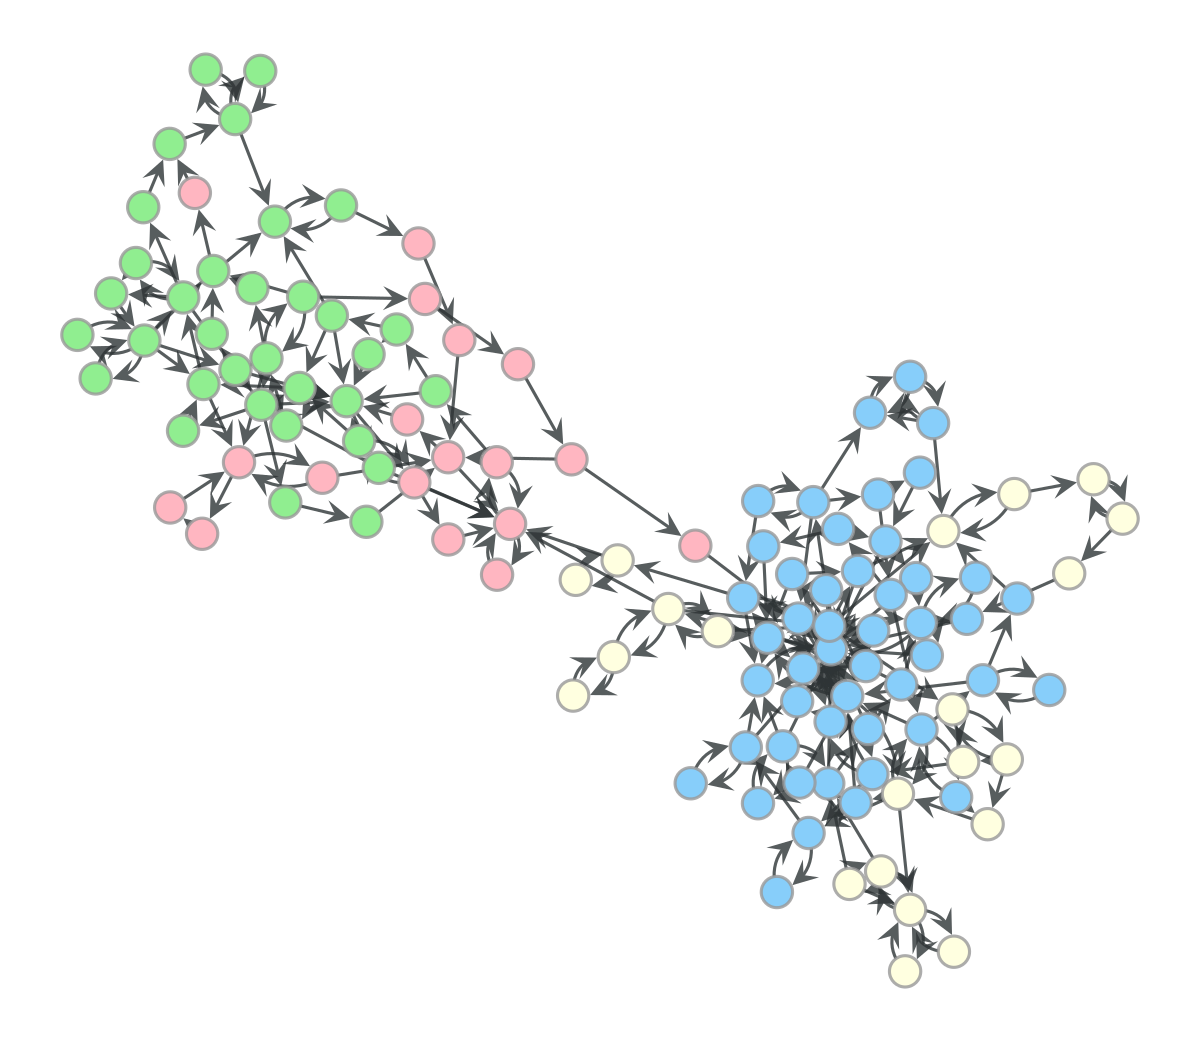

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff845e291d0, at 0x7ff83f88a588>

In [45]:
# Create new vertex property
vertex_color = hyperlink_g.vp["vertex_color"] = hyperlink_g.new_vp("string")

print("Hyperlink + Text Consensus Partition")
print("Uncertainty associated to consensus partition is ", hyperlink_text_consensus_partitions_sd)
# Color doc network.
colors = ["lightskyblue", "lightpink", "lightgreen", "lightyellow"]
colormap = remap_color_partition_manually(hyperlink_text_consensus_partitions, colors)

# Assign a value to that property for each node of that graph
for v, group in zip(hyperlink_g.vertices(), hyperlink_text_consensus_partitions):
    vertex_color[v] = colormap[group]

gt.graph_draw(hyperlink_g,
              pos=hyperlink_g.vp["pos"],
              vertex_fill_color=hyperlink_g.vertex_properties['vertex_color'])

## Partition overlap and normalised mutual information

Compute heatmap showing the partition overlap and normalised mutual information of hyperlink + text model and Wikipedia labels.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from Utils.doc_clustering import *
sns.set_style("whitegrid")

sns.set(font_scale=2)

def visualise_partition_overlap_results(partition_overlap_avg, partition_overlap_std , cols, title):
    """
    Construct heat-map to show partition overlap matrix.
    """
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2)
    
    mask = np.zeros_like(partition_overlap_avg)
    mask[np.triu_indices_from(mask, k=1)] = True
    final_df = pd.DataFrame(partition_overlap_avg, columns=cols, index=cols)
    labels = (np.asarray(["{0:.2f}\n({1:.2f})".format(partition_overlap_avg_entry, partition_overlap_std_entry) for partition_overlap_avg_entry, partition_overlap_std_entry in zip(partition_overlap_avg.flatten(), partition_overlap_std.flatten())])).reshape(len(partition_overlap_avg), len(partition_overlap_avg))    
    ax = sns.heatmap(data=final_df, annot = labels, mask=mask, linewidth=0.5, square=True, cmap="Blues", fmt='')
    ax.set_title(title)
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)
    sns.axes_style("white")
    sns.set_style("whitegrid")
    plt.show()

In [47]:
def compute_partition_overlap(partition_i, partition_j):
    """
    Compute the maximum partition overlap between the two partitions.
    """
    return gt.partition_overlap(partition_i, partition_j)


def _max_overlap_partition(partitions):
    """
    Helper function for calculating the partition overlap. Take in list of partitions from 2 different models and
    computes the partition overlap between the two models' partitions.

    partitions: list of list
    The partitions will be two lists of lists of size N_ITER where each list corresponds to partitions of a model 
    where we retrieve N_ITER partitions each time.

    Return: list of partition overlap between partitions.
    """
    n = len(partitions) # 10 * 10, depends on number of iterations to retrieve partitions
    overlap_partition_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            overlap_partition_matrix[i,j] = compute_partition_overlap(partitions[i], partitions[j])
    return list(overlap_partition_matrix[np.triu_indices(n,1)]) # return upper triangle for array.

def construct_maximum_overlap_partition_matrix(partitions, true_partition):
    """
    Compute maximum overlap partition matrix for all partitions generated by models against true partition.

    partitions: list of list of partitions for each model. 
    true_partition: single list of true partitions.

    Remark: For example, we may generate 20 different partitions for the hSBM and compare it to the true partitions.
    First column is for the true partition.
    """
    num_models = len(partitions) # number of different models we are testing.
    # Store the average and standard deviation of partition overlap between partitions in a n x n matrix
    max_partition_overlap_avg = np.zeros((num_models+1, num_models+1))
    max_partition_overlap_std = np.zeros((num_models+1, num_models+1))

    # Iterate through NMI matrix and compute partition overlap between models excluding the ground truth.
    # We do not iterate through the first column.
    for i in range(1, num_models+1):
        for j in range(i, num_models+1):
            partition_overlaps = _max_overlap_partition(partitions[i-1] + partitions[j-1]) # retrieve list of partitions for model i-1 and model j-1
            # Store mean and std of partition overlap.
            max_partition_overlap_avg[i,j] = np.average(partition_overlaps)
            max_partition_overlap_std[i,j] = np.std(partition_overlaps)

    max_partition_overlap_avg[0,0], max_partition_overlap_std[0,0] = 1, 0 # true partition should have NMI of 1 with itself.
    # Compute the NMI for each model against ground truth. Corresponds to 1st column of NMI matrix.
    for i in range(num_models):
        # Compute NMI of model's partition with ground truth labels.
        partition_overlap_with_true = [compute_partition_overlap(p, true_partition) for p in partitions[i]]
        max_partition_overlap_avg[0, i+1] = np.average(partition_overlap_with_true)
        max_partition_overlap_std[0, i+1] = np.std(partition_overlap_with_true)
    return (max_partition_overlap_avg.T, max_partition_overlap_std.T)            

In [48]:
def map_partition_to_int(partition):
    # Helper function for Wikipedia labelling for heatmap.
    cat_map = {}
    for id, cat in enumerate(set(partition)):
        cat_map[cat] = id

    int_mapping = []
    for entry in partition:
        int_mapping.append( cat_map[entry] )

    return int_mapping

true_partition_int = map_partition_to_int(true_partition)

In [49]:
# Compute the average partition overlap and standard deviation
max_partition_overlap_avg, max_partition_overlap_std = construct_maximum_overlap_partition_matrix([hyperlink_text_hsbm_partitions], true_partition_int)

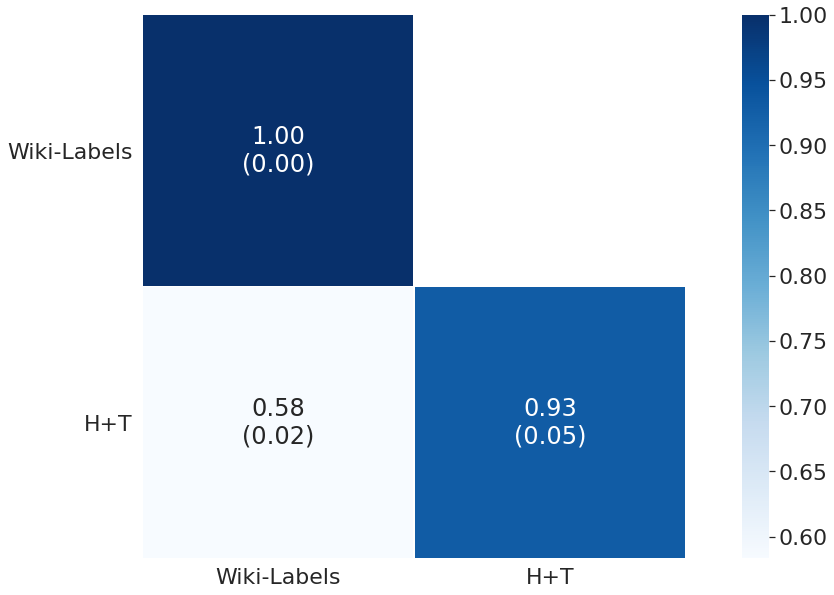

In [51]:
column_names = ["Wiki-Labels", "H+T"]
visualise_heatmap_results(max_partition_overlap_avg, max_partition_overlap_std, column_names, r"")

In [52]:
from Utils.doc_clustering import *
sns.set_style("whitegrid")

sns.set(font_scale=2)

def visualise_heatmap_results(averages, std , cols, title):
    """
    Construct heat-map to show NMI of partitions.
    """
    plt.figure(figsize=(20, 10))
    sns.axes_style("white")
    sns.set_style("whitegrid")

    mask = np.zeros_like(averages)
    mask[np.triu_indices_from(mask, k=1)] = True
    final_df = pd.DataFrame(averages, columns=cols, index=cols)
    labels = (np.asarray(["{0:.2f}\n({1:.2f})".format(averages_entry, std_entry) for averages_entry, std_entry in zip(averages.flatten(), std.flatten())])).reshape(len(averages), len(averages))    
    ax = sns.heatmap(data=final_df, annot = labels, mask=mask, linewidth=0.5, square=True, cmap="Blues", fmt='')
    ax.set_title(title)
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)
    plt.show()

In [53]:
# Compute the average NMI and standard deviation
nmi_avg, nmi_std = construct_nmi_matrix([hyperlink_text_hsbm_partitions], true_partition)

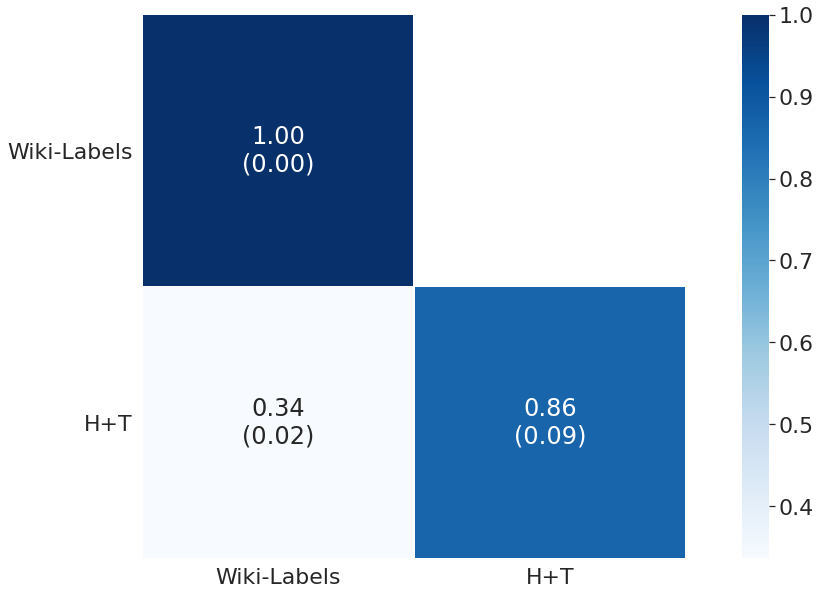

In [54]:
column_names = ["Wiki-Labels", "H+T"]
visualise_heatmap_results(nmi_avg, nmi_std, column_names, r"")

# Topic Modelling

We now show how this framework tackles the problem of topic modelling simultaneously.

In [55]:
# Get topics for one run of SBM at highest non-trivial level
hyperlink_text_hsbm_states[0].get_topics(l=2, n=10)

{0: [('structure', 0.039764359351988215),
  ('central', 0.016200294550810016),
  ('primary', 0.01521845851742759),
  ('surface', 0.01521845851742759),
  ('commonly', 0.01521845851742759),
  ('side', 0.01521845851742759),
  ('electron', 0.014236622484045164),
  ('chemistry', 0.012763868433971527),
  ('atom', 0.011782032400589101),
  ('stable', 0.011291114383897889)],
 1: [('protein', 0.01978114478114478),
  ('cell', 0.017676767676767676),
  ('bind', 0.013888888888888888),
  ('gene', 0.013888888888888888),
  ('site', 0.013888888888888888),
  ('human', 0.013468013468013467),
  ('dna', 0.013047138047138047),
  ('activity', 0.012205387205387205),
  ('pathway', 0.011784511784511785),
  ('cellular', 0.010942760942760943)],
 2: [('chemical', 0.013094718463553033),
  ('enzyme', 0.010475774770842427),
  ('ion', 0.009166302924487123),
  ('compound', 0.007420340462680052),
  ('reaction', 0.007420340462680052),
  ('concentration', 0.006547359231776516),
  ('store', 0.006110868616324749),
  ('water'

In [57]:
doc_num = 0
print(hyperlink_text_hsbm_states[0].documents[doc_num]) # see document name
# Retrieve proportion of topics for document 0
hyperlink_text_hsbm_states[0].get_topicProportion(doc_num, l=2)

Adenosine triphosphate


[(0, 0.03945371775417299),
 (1, 0.08497723823975721),
 (2, 0.251896813353566),
 (3, 0.13050075872534142),
 (4, 0.04704097116843703),
 (5, 0.15629742033383914),
 (6, 0.08801213960546282),
 (7, 0.10166919575113809),
 (8, 0.04400606980273141),
 (9, 0.019726858877086494),
 (10, 0.030349013657056147),
 (11, 0.006069802731411229)]

We now retrieve the topics associated to the consensus partition of Hyperlink + Text model.

In [64]:
def get_word_type_blocks(h_t_state, h_t_graph, level):
    """
    Retrieve the block assignment of WORD types for H+T model.
    """
    partitions = []
    num_of_groups = []
    entropies = []
    block_SBM_partitions = {} # store dictionary to map nodes to partition.
    b = h_t_state.project_level(level).get_blocks()
    # Need to specify to retrieve partitions for WORD type nodes.
    for node in h_t_graph.vertices():
        if h_t_graph.vp['kind'][node] == 1:
            block_SBM_partitions[h_t_graph.vp.name[node]] = b[node]                    
    
    # Retrieve the partition from the SBM and store as parameter.    
    partition = h_t_graph.vp["partition"] = h_t_graph.new_vp("int")
    # Assign partition label to node properties.
    for v in h_t_graph.vertices():
        if h_t_graph.vp['kind'][v] == 1:
            partition[v] = block_SBM_partitions[h_t_graph.vp.name[v]]
    # IGNORE FIRST 120 NODES (there are document nodes)
    partitions.append(list(h_t_graph.vp.partition)[120:])
    num_of_groups.append(len(set(partitions[0])))
    entropies.append(h_t_state.entropy())
    return (partitions, num_of_groups, entropies)

In [67]:
H_T_word_hsbm_partitions = []
H_T_word_hsbm_num_groups = []
for i in range(len(levels)):
    print(i)
    word_partitions, num_word_groups, en = get_word_type_blocks(hyperlink_text_hsbm_states[i].state, hyperlink_text_hsbm_states[i].g, levels[i])
    H_T_word_hsbm_partitions.append(word_partitions[0])
    H_T_word_hsbm_num_groups.append(num_word_groups)

0
1
2


We now retrieve the consensus partitions for the document and word type nodes respectively. We now "count" the number of edges between document clusters and word type groups (i.e. topics) in order to compute the distributions required.

In [69]:
h_t_doc_consensus = gt.partition_overlap_center(hyperlink_text_hsbm_partitions)[0]

In [71]:
D = len((h_t_doc_consensus)) # number of document nodes

h_t_word_consensus = gt.partition_overlap_center(H_T_word_hsbm_partitions)[0]
h_t_word_consensus += len(set(h_t_doc_consensus)) # to get cluster number to not start from 0

V = len((h_t_word_consensus)) # number of word-type nodes
# number of word-tokens (edges excluding hyperlinks)
N = int(np.sum([hyperlink_text_hsbm_states[0].g.ep.edgeCount[e] for e in hyperlink_text_hsbm_states[0].g.edges() if hyperlink_text_hsbm_states[0].g.ep['edgeType'][e]== 0 ])) 

# Number of blocks
B = len(set(h_t_word_consensus)) + len(set(h_t_doc_consensus))

# Count labeled half-edges, total sum is # of edges
# Number of half-edges incident on word-node w and labeled as word-group tw
n_wb = np.zeros((V,B)) # will be reduced to (V, B_w)

# Number of half-edges incident on document-node d and labeled as document-group td
n_db = np.zeros((D,B)) # will be reduced to (D, B_d)

# Number of half-edges incident on document-node d and labeled as word-group tw
n_dbw = np.zeros((D,B))  # will be reduced to (D, B_w)


In [73]:
# All graphs created the same for each H+T model
for e in hyperlink_text_hsbm_states[0].g.edges():
    # Each edge will be between a document node and word-type node
    if hyperlink_text_hsbm_states[0].g.ep.edgeType[e] == 0:        
        # v1 ranges from 0, 1, 2, ..., D - 1
        # v2 ranges from D, ..., (D + V) - 1 (V # of word types)
        v1 = int(e.source()) # document node index
        v2 = int(e.target()) # word type node index
        # z1 will have values from 1, 2, ..., B_d; document-group i.e document block that doc node is in 
        # z2 will have values from B_d + 1, B_d + 2,  ..., B_d + B_w; word-group i.e word block that word type node is in
        # Recall that h_t_word_consensus starts at 0 so need to -120
        z1, z2 = h_t_doc_consensus[v1], h_t_word_consensus[v2-120]
        n_wb[v2-D,z2] += 1 # word type v2 is in topic z2
        n_db[v1,z1] += 1 # document v1 is in doc cluster z1
        n_dbw[v1,z2] += 1 # document v1 has a word in topic z2

In [74]:
n_db = n_db[:, np.any(n_db, axis=0)] # (D, B_d)
n_wb = n_wb[:, np.any(n_wb, axis=0)] # (V, B_w)
n_dbw = n_dbw[:, np.any(n_dbw, axis=0)] # (D, B_d)

B_d = n_db.shape[1]  # number of document groups
B_w = n_wb.shape[1] # number of word groups (topics)

In [75]:
# Group membership of each word-type node in topic, matrix of ones or zeros, shape B_w x V
# This tells us the probability of topic over word type
p_tw_w = (n_wb / np.sum(n_wb, axis=1)[:, np.newaxis]).T

# Group membership of each doc-node, matrix of ones of zeros, shape B_d x D
p_td_d = (n_db / np.sum(n_db, axis=1)[:, np.newaxis]).T

# Mixture of word-groups into documents P(t_w | d), shape B_d x D
p_tw_d = (n_dbw / np.sum(n_dbw, axis=1)[:, np.newaxis]).T

# Per-topic word distribution, shape V x B_w
p_w_tw = n_wb / np.sum(n_wb, axis=0)[np.newaxis, :]


h_t_consensus_summary = {}
h_t_consensus_summary['Bd'] = B_d # Number of document groups
h_t_consensus_summary['Bw'] = B_w # Number of word groups
h_t_consensus_summary['p_tw_w'] = p_tw_w # Group membership of word nodes
h_t_consensus_summary['p_td_d'] = p_td_d # Group membership of document nodes
h_t_consensus_summary['p_tw_d'] = p_tw_d # Topic proportions over documents
h_t_consensus_summary['p_w_tw'] = p_w_tw # Topic distribution over words

In [76]:
def get_topics_h_t_consensus_model(groups, words, n=10):
    """
    Retrieve topics in consensus partition for H+T model.
    """
    dict_groups = groups
    Bw = dict_groups['Bw'] # number of word-groups
    p_w_tw = dict_groups['p_w_tw'] # topic proportions over documents
    words = words
    # Loop over all word-groups
    dict_group_words = {}
    for tw in range(Bw):
        p_w_ = p_w_tw[:, tw]
        ind_w_ = np.argsort(p_w_)[::-1]
        list_words_tw = []
        for i in ind_w_[:n]:
            if p_w_[i] > 0:
                list_words_tw+=[(words[i],p_w_[i])]
            else:
                break
        dict_group_words[tw] = list_words_tw
    return dict_group_words    

In [77]:
g_words = [ hyperlink_text_hsbm_states[0].g.vp['name'][v] for v in  hyperlink_text_hsbm_states[0].g.vertices() if hyperlink_text_hsbm_states[0].g.vp['kind'][v]==1   ]


In [78]:
dict_groups = get_topics_h_t_consensus_model(h_t_consensus_summary, g_words)

In [81]:
# Write out topics as dataframe
topic_csv_dict = {}
for key in dict_groups.keys():
    topic_csv_dict[key] = [entry[0] for entry in dict_groups[key]]

In [82]:
keys = topic_csv_dict.keys()
topics_df = pd.DataFrame()

for key in dict_groups.keys():
    temp_df = pd.DataFrame(topic_csv_dict[key], columns=[key])
    topics_df = pd.concat([topics_df, temp_df], ignore_index=True, axis=1)

We can now retrieve the top 10 words associated to topics associated to consensus partition.

In [83]:
topics_df

,0,1,2,3,4,5,6,7,8,9,10
0,protein,involve,one,molecular,system,sequence,chemical,group,vector,element,analysis
1,cell,work,also,information,time,domain,stable,space,equation,basis,data
2,site,occur,use,molecule,state,acid,pattern,field,dimension,along,predict
3,bind,factor,form,target,second,research,ion,define,classical,translation,transform
4,gene,specific,function,family,energy,signal,configuration,theory,denote,class,operation
5,human,within,give,bond,particle,encode,compound,point,linear,matrix,series
6,dna,expression,two,chemistry,mass,body,label,value,coordinate,right,loop
7,activity,region,may,hydrogen,charge,grow,reaction,constant,mechanic,measure,electron
8,pathway,produce,example,location,quantity,event,oxygen,simple,let,c,wave
9,rna,process,however,convert,current,cellular,water,quantum,lie,x,plane
